In [107]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import time

Data Download & Loader

In [108]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#data download code
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)

#loader code
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [109]:
torch.cuda.get_device_name(0)
# 'Geforce RTX 2080 Ti'
torch.cuda.is_available()
# True
torch.cuda.device_count()
# 6

6

Data show

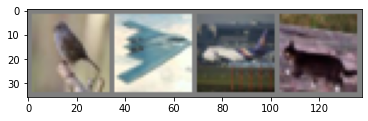

 bird plane plane   cat
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([2, 0, 0, 3])


In [110]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print(type(images), images.shape)
print(type(labels), labels.shape, labels)

Make Model

In [111]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':
            self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x
    
net = MLP(32*32*3, 10, 100, 2, 'relu')
print(net)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


Optimizer & Loss Function

In [112]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Experiment

In [118]:
def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    
    net.cuda()
    
    print(net)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.view(-1, 32*32*3) # 다차원 데이터를 1차원으로 폈을 때 뒤에꺼로 나눈 값이 앞의 차원이 됨.
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            # ===== parameter update ===== #
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss : %.3f' %(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
        # ===== Validation ===== #
        correct = 0
        total = 0
        val_loss = 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 32*32*3)
                
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_loss = val_loss / len(valloader)   
            val_acc = 100 * correct / total
            
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))

        # ===== Evaluation ===== #
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.view(-1, 32*32*3)
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            test_acc = 100 * correct / total

        print('Accuracy of the network on the 10000 test images: {:2.2f}%   Loss : {:2.2f}'.format(acc, val_loss))

In [119]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10 
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9

args.epoch = 2

start = time.time()
experiment(args)
print("time : ", time.time() - start)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss : 2.296
[1,  4000] loss : 2.110
[1,  6000] loss : 1.923
[1,  8000] loss : 1.808
[1, 10000] loss : 1.729
Epoch 0, Train Loss: 19733.00364780426, Val Loss: 1.6929616589665413, Val Acc: 39.06
Accuracy of the network on the 10000 test images: 47.58%   Loss : 1.69
[2,  2000] loss : 1.668
[2,  4000] loss : 1.645
[2,  6000] loss : 1.606
[2,  8000] loss : 1.586
[2, 10000] loss : 1.579
Epoch 1, Train Loss: 16165.37567666173, Val Loss: 1.5878789062261582, Val Acc: 43.77
Accuracy of the network on the 10000 test images: 47.58%   Loss : 1.59
time :  261.4872803688049